# 05/05

＊使用ckip進行切字，模型的表現並沒有明顯的改變。

＊調整word imbedding 的dimension

＊加“深”類型經網路的層數，看能不能在training dataset得到更好的結果（in terms of "recall"）

# Import packages and Datasets



In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import gc #Garbage Collector interface
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score #The F-Measure is a popular metric for imbalanced classification.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import Google Drive 套件
from google.colab import drive

# 將自己的雲端硬碟掛載上去
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 透過 gdrive/My Drive/... 來存取檔案
data_df = pd.read_excel('gdrive/My Drive/金融科技Final_project/ckiptagger_data.xlsx')

In [4]:
data_df.head()

,個股代號,公司簡稱,事件日,TCRI(年/月),事件強度,大事件類別,小事件類別,事件內容,content_tokenized
0,1218,泰山,20190101,6(2018/09),0,M_經營層,MT06_高管異動,發言人林俐婉內部調動由江巍峰接任,發言人 林俐婉 內部 調動 由 江巍峰 接任
1,1503,士電,20190101,4(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動由莊文清接任,內部 稽核 主管 林志強 內部 調動 由 莊文清 接任
2,1504,東元,20190101,4(2018/09),0,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動由林鴻名接任,會計 主管 藍俊雄 內部 調動 由 林鴻名 接任
3,1709,和益,20190101,5(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動由曾筱茜接任,內部 稽核 主管 游本詮 內部 調動 由 曾筱茜 接任
4,1721,三晃,20190101,7(2018/09),0,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動由王婷渝接任,財務 經理 洪廷宜 內部 調動 由 王婷渝 接任


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23703 entries, 0 to 23702
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   個股代號               23703 non-null  int64 
 1   公司簡稱               22775 non-null  object
 2   事件日                23703 non-null  int64 
 3   TCRI(年/月)          23703 non-null  object
 4   事件強度               23703 non-null  int64 
 5   大事件類別              23703 non-null  object
 6   小事件類別              23703 non-null  object
 7   事件內容               23703 non-null  object
 8   content_tokenized  23703 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


# Data preprocessing

In [6]:
import keras
MAX_NUM_WORDS = 10000
tokenizer = keras .preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

corpus = data_df.content_tokenized

Using TensorFlow backend.


In [7]:
corpus

0                                   發言人 林俐婉 內部 調動 由 江巍峰 接任
1                              內部 稽核 主管 林志強 內部 調動 由 莊文清 接任
2                                 會計 主管 藍俊雄 內部 調動 由 林鴻名 接任
3                              內部 稽核 主管 游本詮 內部 調動 由 曾筱茜 接任
4                                 財務 經理 洪廷宜 內部 調動 由 王婷渝 接任
                               ...                        
23698    2018年 09月 累計 營收 1496639千 元 年增 1622018年 09月 單月 ...
23699                       20191231 收盤價 3500 元 月 報酬 下跌 43
23700    世界 先進 評估 跨足 晶圓 薄化 領域 搶進 晶圓 薄化 市場 機率 高晶圓 薄化 是 晶...
23701    1 雷虎 科技 與 香港 中澤 文化 投資 股份 有限公司 仲裁 案號 補充 公告 雷虎 科...
23702    商億 KY 公告 董事會 為 配合 柬埔寨 孫 公司 發展 需求 擬 透過 子公司 Shay...
Name: content_tokenized, Length: 23703, dtype: object

In [8]:
tokenizer.fit_on_texts(corpus)

x = tokenizer.texts_to_sequences(corpus)

len(x)

x[:1]

for seq in x[:1]:
    print([tokenizer.index_word[idx] for idx in seq])
    
for seq in x[:20]:
    print(len(seq), seq[:5], ' ...')
    
max_seq_len = max([
    len(seq) for seq in x])

max_seq_len

MAX_SEQUENCE_LENGTH = 1000

['發言人', '內部', '調動', '由', '接任']
5 [405, 68, 128, 23, 76]  ...
7 [68, 358, 133, 68, 128]  ...
6 [292, 133, 68, 128, 23]  ...
7 [68, 358, 133, 68, 128]  ...
6 [94, 426, 68, 128, 23]  ...
6 [239, 133, 68, 128, 23]  ...
8 [217, 196, 23, 76, 405]  ...
13 [422, 24, 63, 6, 4874]  ...
6 [504, 24, 63, 50, 6]  ...
5 [217, 68, 128, 23, 76]  ...
5 [217, 68, 128, 23, 76]  ...
196 [2790, 760, 2040, 1228, 21]  ...
17 [422, 24, 63, 6, 6512]  ...
6 [292, 133, 68, 128, 23]  ...
6 [94, 426, 68, 128, 23]  ...
6 [292, 133, 68, 128, 23]  ...
5 [217, 68, 128, 23, 76]  ...
7 [239, 133, 68, 128, 23]  ...
5 [217, 68, 128, 23, 76]  ...
5 [217, 68, 128, 23, 76]  ...


In [0]:
x = keras .preprocessing .sequence .pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)

# Model building: Predict "事件強度"

In [0]:
y = data_df["事件強度"]

## Split data into training dataset and testing dataset

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## We have the issue of imbalanced data

In [12]:
y_train.value_counts()

-1    8557
 0    6722
 1    2807
-2     521
-3     219
 2      76
 3      60
Name: 事件強度, dtype: int64

## Visualize the distribution of each target class

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20107 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20214 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20107 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20214 missing from current font.
  font.set_te

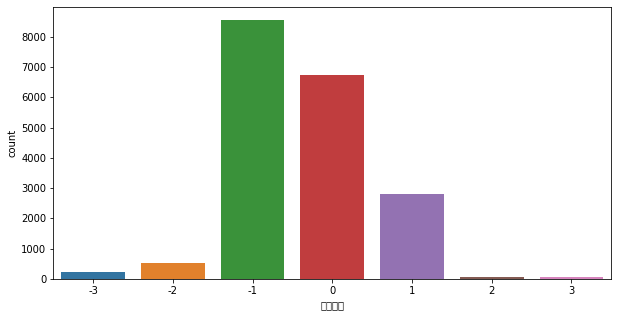

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(y_train)

## Calculate class weight

In [0]:
# Let's import the module first
from sklearn.utils import class_weight

# In order to calculate the class weight do the following
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

## Encode target variable

In [0]:
enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(np.asarray(y_train).reshape(-1, 1))
y_test = enc.transform(np.asarray(y_test).reshape(-1, 1))

## Model1:

word embeddings: 256

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15169 samples, validate on 3793 samples
Epoch 1/10
15169/15169 [==============================] - 278s 18ms/step - loss: 1.2150 - accuracy: 0.5568 - val_loss: 0.8236 - val_accuracy: 0.6873
Epoch 2/10
15169/15169 [==============================] - 274s 18ms/step - loss: 0.5896 - accuracy: 0.7917 - val_loss: 0.5163 - val_accuracy: 0.8147
Epoch 3/10
15169/15169 [==============================] - 282s 19ms/step - loss: 0.3521 - accuracy: 0.8838 - val_loss: 0.5116 - val_accuracy: 0.8249
Epoch 4/10
15169/15169 [==============================] - 276s 18ms/step - loss: 0.2389 - accuracy: 0.9231 - val_loss: 0.5352 - val_accuracy: 0.8313
Epoch 5/10
15169/15169 [==============================] - 270s 18ms/step - loss: 0.1601 - accuracy: 0.9480 - val_loss: 0.6042 - val_accuracy: 0.8481
Epoch 6/10
15169/15169 [==============================] - 286s 19ms/step - loss: 0.1206 - accuracy: 0.9614 - val_loss: 0.6135 - val_accuracy: 0.8503
Epoch 7/10
15169/15169 [==============================] -

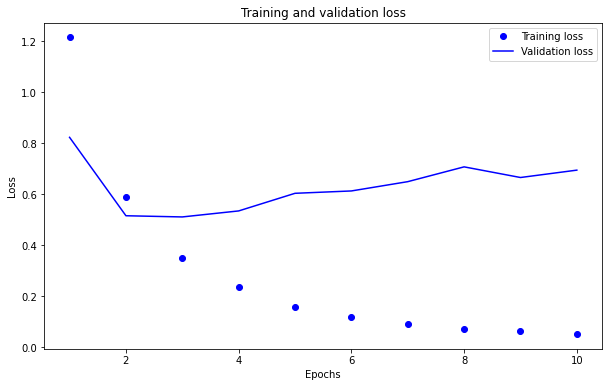

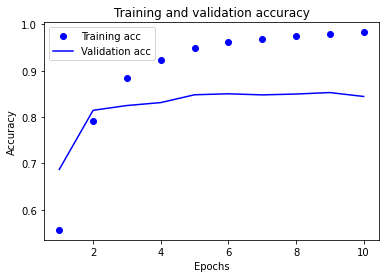

In [16]:
# Build our neural network model with LSTM

from keras import models
from keras import layers

max_features = 25000

from keras.layers import LSTM
model = models.Sequential()
model.add(layers.Embedding(max_features, 256))  ######output dimension: 512
model.add(layers.LSTM(128,return_sequences=True))
model.add(layers.LSTM(128,return_sequences=True))
model.add(layers.LSTM(128))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=500,
                   validation_split=0.2,
                    class_weight = class_weights)

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on training set

In [17]:
preds_Y_train = model.predict(X_train)
preds_Y_train =(preds_Y_train>0.5).astype(int)

preds_Y_train = enc.inverse_transform(preds_Y_train)
y_train = enc.inverse_transform(y_train)

accuracy = accuracy_score(y_train, preds_Y_train)
precision = precision_score(y_train, preds_Y_train,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_train, preds_Y_train,average=None)
f1 = f1_score(y_train, preds_Y_train,average=None)
c_matrix = confusion_matrix(y_train, preds_Y_train,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9572829870266849

precision: [0.73764259 0.82685512 0.97915935 0.95611285 0.93964286 0.94285714
 1.        ]

recall: [0.88584475 0.89827255 0.9773285  0.95284142 0.93729961 0.43421053
 0.96666667]

F1 score: [0.80497925 0.86108556 0.97824307 0.95447433 0.93846977 0.59459459
 0.98305085]

Confusion matrix: 
[[ 194   21    3    1    0    0    0]
 [  11  468   22   18    2    0    0]
 [  12   24 8363  137   20    1    0]
 [  21   27  131 6405  137    1    0]
 [  10   11   21  134 2631    0    0]
 [  13   15    1    4   10   33    0]
 [   2    0    0    0    0    0   58]]


## Performance on testing set

In [18]:
preds_Y_test = model.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

preds_Y_test = enc.inverse_transform(preds_Y_test)
y_test = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test, preds_Y_test)
precision = precision_score(y_test, preds_Y_test,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test, preds_Y_test,average=None)
f1 = f1_score(y_test, preds_Y_test,average=None)
c_matrix = confusion_matrix(y_test, preds_Y_test,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8460240455600084

precision: [0.44444444 0.51824818 0.93249534 0.81639929 0.7577548  0.66666667
 1.        ]

recall: [0.66666667 0.6173913  0.92560074 0.83121597 0.70856354 0.11111111
 0.92307692]

F1 score: [0.53333333 0.56349206 0.92903525 0.82374101 0.73233405 0.19047619
 0.96      ]

Confusion matrix: 
[[  36   11    2    4    1    0    0]
 [   7   71   15   18    4    0    0]
 [   9   23 2003  109   20    0    0]
 [  18   18  105 1374  137    1    0]
 [   8    5   21  177  513    0    0]
 [   2    9    2    1    2    2    0]
 [   1    0    0    0    0    0   12]]


## Model 2 :

word embeddings: 512

In [0]:
y = data_df["事件強度"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(np.asarray(y_train).reshape(-1, 1))
y_test = enc.transform(np.asarray(y_test).reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15169 samples, validate on 3793 samples
Epoch 1/10
15169/15169 [==============================] - 300s 20ms/step - loss: 1.1836 - accuracy: 0.5673 - val_loss: 0.7189 - val_accuracy: 0.7208
Epoch 2/10
15169/15169 [==============================] - 302s 20ms/step - loss: 0.5376 - accuracy: 0.8146 - val_loss: 0.4950 - val_accuracy: 0.8305
Epoch 3/10
15169/15169 [==============================] - 298s 20ms/step - loss: 0.3364 - accuracy: 0.8882 - val_loss: 0.5001 - val_accuracy: 0.8344
Epoch 4/10
15169/15169 [==============================] - 300s 20ms/step - loss: 0.2217 - accuracy: 0.9287 - val_loss: 0.5545 - val_accuracy: 0.8439
Epoch 5/10
15169/15169 [==============================] - 297s 20ms/step - loss: 0.1553 - accuracy: 0.9490 - val_loss: 0.5998 - val_accuracy: 0.8421
Epoch 6/10
15169/15169 [==============================] - 299s 20ms/step - loss: 0.1157 - accuracy: 0.9631 - val_loss: 0.6632 - val_accuracy: 0.8413
Epoch 7/10
15169/15169 [==============================] -

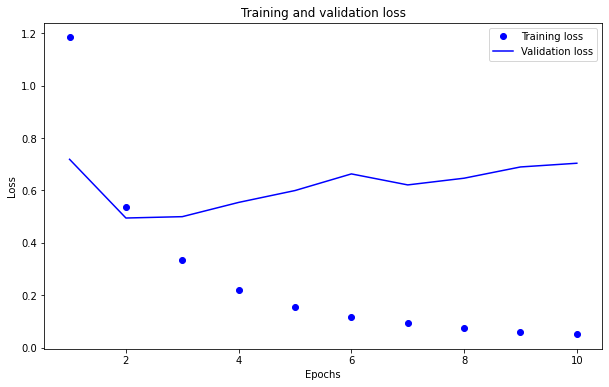

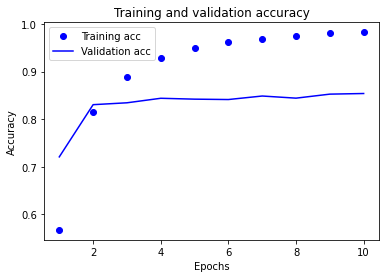

In [20]:
# Build our neural network model with LSTM

from keras import models
from keras import layers

max_features = 25000

from keras.layers import LSTM
model = models.Sequential()
model.add(layers.Embedding(max_features, 512))  ######output dimension: 512
model.add(layers.LSTM(128,return_sequences=True))
model.add(layers.LSTM(128,return_sequences=True))
model.add(layers.LSTM(128))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=500,
                   validation_split=0.2,
                    class_weight = class_weights)

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on training set

In [21]:
preds_Y_train = model.predict(X_train)
preds_Y_train =(preds_Y_train>0.5).astype(int)

preds_Y_train = enc.inverse_transform(preds_Y_train)
y_train = enc.inverse_transform(y_train)

accuracy = accuracy_score(y_train, preds_Y_train)
precision = precision_score(y_train, preds_Y_train,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_train, preds_Y_train,average=None)
f1 = f1_score(y_train, preds_Y_train,average=None)
c_matrix = confusion_matrix(y_train, preds_Y_train,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9586541504060753

precision: [0.788      0.79292929 0.98387287 0.94764474 0.96162444 0.65
 0.96774194]

recall: [0.89954338 0.90403071 0.97674419 0.96667658 0.919487   0.17105263
 1.        ]

F1 score: [0.84008529 0.84484305 0.98029557 0.95706606 0.94008377 0.27083333
 0.98360656]

Confusion matrix: 
[[ 197   19    1    1    1    0    0]
 [   7  471   16   27    0    0    0]
 [  16   27 8358  141   13    1    1]
 [  11   25  102 6498   82    4    0]
 [  14    7   17  185 2581    2    1]
 [   5   45    1    5    7   13    0]
 [   0    0    0    0    0    0   60]]


## Performance on testing set

In [22]:
preds_Y_test = model.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

preds_Y_test = enc.inverse_transform(preds_Y_test)
y_test = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test, preds_Y_test)
precision = precision_score(y_test, preds_Y_test,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test, preds_Y_test,average=None)
f1 = f1_score(y_test, preds_Y_test,average=None)
c_matrix = confusion_matrix(y_test, preds_Y_test,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.85446108415946

precision: [0.475      0.56390977 0.9354537  0.81221461 0.80577849 0.
 0.92857143]

recall: [0.7037037  0.65217391 0.92421442 0.86085904 0.69337017 0.
 1.        ]

F1 score: [0.56716418 0.60483871 0.92980009 0.83582966 0.74536006 0.
 0.96296296]

Confusion matrix: 
[[  38   11    2    3    0    0    0]
 [   7   75   13   19    1    0    0]
 [  11   18 2000  115   19    0    1]
 [  17   14  100 1423   99    0    0]
 [   7    2   22  190  502    1    0]
 [   0   13    1    2    2    0    0]
 [   0    0    0    0    0    0   13]]


# Model building: Predict "大事件類別"

In [0]:
y = data_df["大事件類別"]

## Split data into training dataset and testing dataset

In [0]:
# Split data to training data and testing data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## We have the issue of imbalanced data

In [46]:
y_train.value_counts()

I_產業前景       12111
M_經營層         4856
F_市場交易        1176
R_危機           410
A_會計/財報分析      409
Name: 大事件類別, dtype: int64

## Visualize the proportion of each target class

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29986 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26223 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29151 missing from current font.
  font.set_

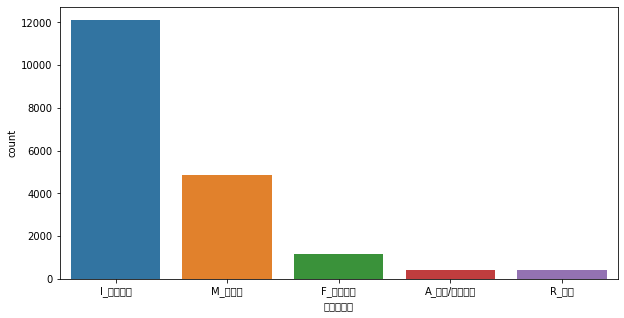

In [47]:
# Visualize the proportion of each target class

plt.figure(figsize=(10,5))
sns.countplot(y_train)

## Calculate class weight

In [0]:
# Calculate class weight

# Let's import the module first
from sklearn.utils import class_weight

# In order to calculate the class weight do the following
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

## Encode target variable

In [0]:
enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(np.asarray(y_train).reshape(-1, 1))
y_test = enc.transform(np.asarray(y_test).reshape(-1, 1))

## Model 3 :

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15169 samples, validate on 3793 samples
Epoch 1/10
15169/15169 [==============================] - 47s 3ms/step - loss: 1.0057 - accuracy: 0.6882 - val_loss: 0.5122 - val_accuracy: 0.8632
Epoch 2/10
15169/15169 [==============================] - 47s 3ms/step - loss: 0.3676 - accuracy: 0.8891 - val_loss: 0.2629 - val_accuracy: 0.9191
Epoch 3/10
15169/15169 [==============================] - 46s 3ms/step - loss: 0.1993 - accuracy: 0.9380 - val_loss: 0.1855 - val_accuracy: 0.9370
Epoch 4/10
15169/15169 [==============================] - 46s 3ms/step - loss: 0.1342 - accuracy: 0.9537 - val_loss: 0.1699 - val_accuracy: 0.9470
Epoch 5/10
15169/15169 [==============================] - 46s 3ms/step - loss: 0.0998 - accuracy: 0.9680 - val_loss: 0.1644 - val_accuracy: 0.9541
Epoch 6/10
15169/15169 [==============================] - 46s 3ms/step - loss: 0.0747 - accuracy: 0.9784 - val_loss: 0.1478 - val_accuracy: 0.9578
Epoch 7/10
15169/15169 [==============================] - 46s 3ms/ste

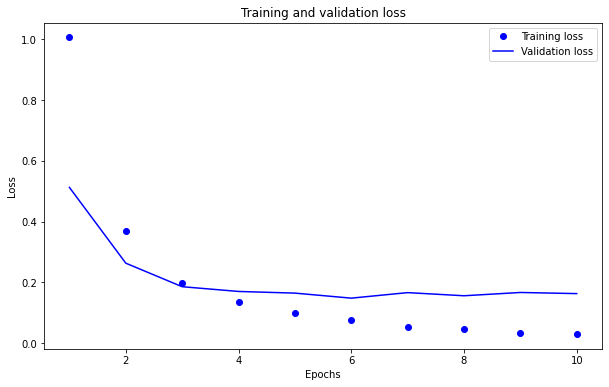

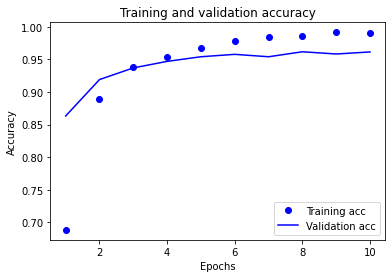

In [50]:
from keras import models
from keras import layers

max_features = 25000

from keras.layers import LSTM
model = models.Sequential()
model.add(layers.Embedding(max_features, 100)) 
model.add(layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2)) # Note we use "dropout" technique here.
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=500,
                   validation_split=0.2,
                    class_weight = class_weights)

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on training set

In [51]:
preds_Y_train = model.predict(X_train)
preds_Y_train =(preds_Y_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_train = enc.inverse_transform(preds_Y_train)
y_train = enc.inverse_transform(y_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
preds_Y_train = le.transform(preds_Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
accuracy = accuracy_score(y_train, preds_Y_train)
precision = precision_score(y_train, preds_Y_train,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_train, preds_Y_train,average=None)
f1 = f1_score(y_train, preds_Y_train,average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_train, preds_Y_train,labels=[0,1,2,3,4])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9885033224343424

precision: [0.87440758 0.9947644  0.99226656 0.98844884 0.9769821 ]

recall: [0.90220049 0.96938776 0.99587152 0.98682043 0.93170732]

F1 score: [0.88808664 0.98191214 0.99406577 0.98763397 0.95380774]

Confusion matrix: 
[[  369     1    30     5     4]
 [    8  1140     9    14     5]
 [   17     1 12061    32     0]
 [   12     1    51  4792     0]
 [   16     3     4     5   382]]


In [53]:
# See the classes in our label encoding method
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

## Performance on testing set

In [54]:
preds_Y_test = model.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test = enc.inverse_transform(preds_Y_test)
y_test = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)
preds_Y_test = le.transform(preds_Y_test)

accuracy = accuracy_score(y_test, preds_Y_test)
precision = precision_score(y_test, preds_Y_test,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test, preds_Y_test,average=None)
f1 = f1_score(y_test, preds_Y_test,average=None)
c_matrix = confusion_matrix(y_test, preds_Y_test,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9685720312170428

precision: [0.74509804 0.9751773  0.97147541 0.97865353 0.96629213]

recall: [0.74509804 0.93537415 0.98898531 0.95589415 0.84313725]

F1 score: [0.74509804 0.95486111 0.98015217 0.96713996 0.90052356]

Confusion matrix: 
[[  76    0   25    0    1]
 [   5  275   11    1    2]
 [   7    1 2963   25    0]
 [   7    2   46 1192    0]
 [   7    4    5    0   86]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

# Model building: Predict "小事件類別"

In [0]:
y = data_df["小事件類別"]

## Split data into training dataset and testing dataset

In [0]:
# Split data to training data and testing data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## We have the issue of imbalanced data

In [58]:
y_train.value_counts()

IS01_營收變動或客戶/商品/通路策略    7645
MT02_董監異動               1618
MT06_高管異動               1533
IP01_成本/產能變動或資本支出       1515
IF02_投資/併購/組織策略         1373
                        ... 
MO03_董監持股未達規定比例            1
RB11_銀行續貸考量                1
MO07_董監財務危機                1
MC03_工安問題                  1
4D_客戶及產品－暴險                1
Name: 小事件類別, Length: 97, dtype: int64

## Visualize the proportion of each target class

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25910 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21205 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25110 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23458 missing from current font.
  font.set_

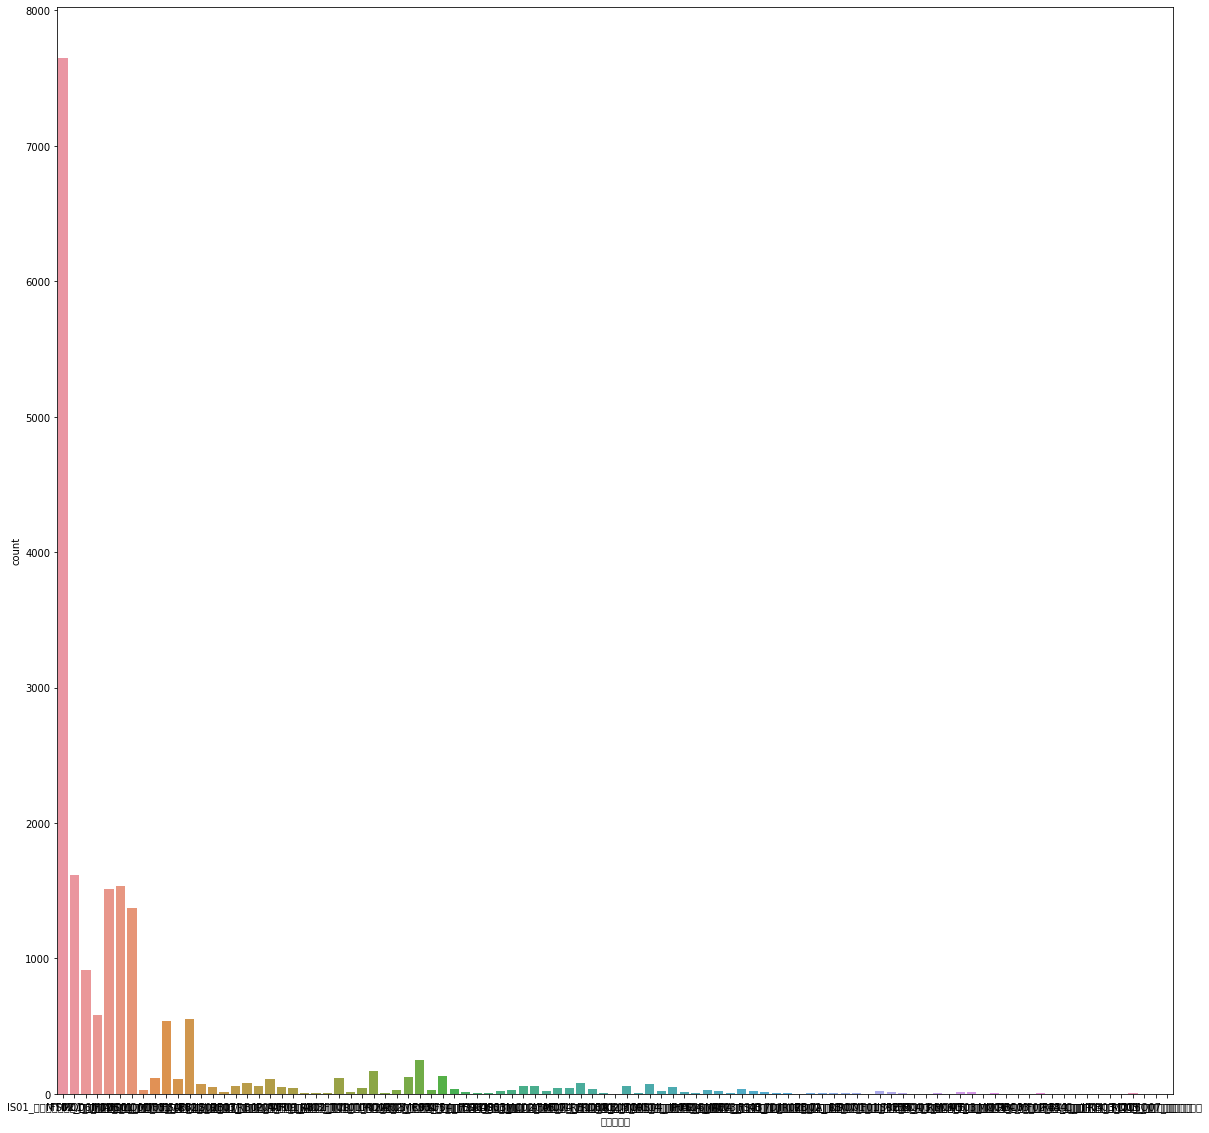

In [59]:
# Visualize the proportion of each target class

plt.figure(figsize=(20,20))
sns.countplot(y_train)

## Calculate class weight

In [0]:
# Calculate class weight

# Let's import the module first
from sklearn.utils import class_weight

# In order to calculate the class weight do the following
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

In [61]:
y_train

17856    IS01_營收變動或客戶/商品/通路策略
13625               MT02_董監異動
17180    IS01_營收變動或客戶/商品/通路策略
7648             FS02_股價暴跌或異常
23641            FS02_股價暴跌或異常
                 ...         
21575            FS02_股價暴跌或異常
5390                MT06_高管異動
860               MO06_董監持股質押
15795    IS01_營收變動或客戶/商品/通路策略
23654         IF02_投資/併購/組織策略
Name: 小事件類別, Length: 18962, dtype: object

## Encode target variable

In [0]:
enc = OneHotEncoder(sparse=False)

# Concatenate our y_train and y_test to fit our one-hot encoder, so we can fit all possible categorical values.
y = np.concatenate((y_train,y_test),axis=0)
enc.fit(y.reshape(-1, 1))

y_train = enc.transform(np.asarray(y_train).reshape(-1, 1))
y_test = enc.transform(np.asarray(y_test).reshape(-1, 1))

## Model 4 :

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15169 samples, validate on 3793 samples
Epoch 1/30
15169/15169 [==============================] - 46s 3ms/step - loss: 3.2710 - accuracy: 0.3859 - val_loss: 2.4526 - val_accuracy: 0.4057
Epoch 2/30
15169/15169 [==============================] - 46s 3ms/step - loss: 2.3538 - accuracy: 0.4029 - val_loss: 2.1754 - val_accuracy: 0.4057
Epoch 3/30
15169/15169 [==============================] - 46s 3ms/step - loss: 1.8616 - accuracy: 0.5531 - val_loss: 1.5322 - val_accuracy: 0.6628
Epoch 4/30
15169/15169 [==============================] - 46s 3ms/step - loss: 1.3306 - accuracy: 0.7031 - val_loss: 1.1627 - val_accuracy: 0.7495
Epoch 5/30
15169/15169 [==============================] - 45s 3ms/step - loss: 1.0457 - accuracy: 0.7628 - val_loss: 1.0013 - val_accuracy: 0.7632
Epoch 6/30
15169/15169 [==============================] - 45s 3ms/step - loss: 0.9085 - accuracy: 0.7806 - val_loss: 0.9194 - val_accuracy: 0.7690
Epoch 7/30
15169/15169 [==============================] - 46s 3ms/ste

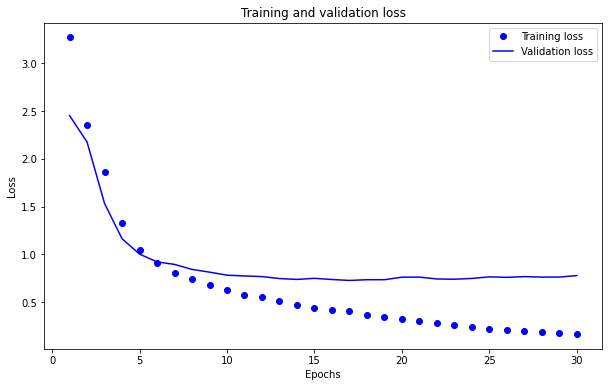

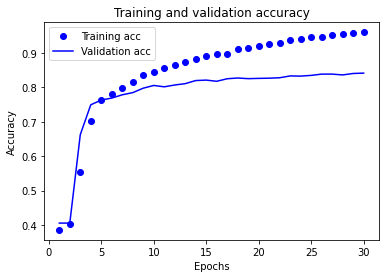

In [63]:
# Build our neural network model with LSTM
# LSTM: 128 units

from keras import models
from keras import layers

max_features = 25000

from keras.layers import LSTM
model = models.Sequential()
model.add(layers.Embedding(max_features, 100)) 
model.add(layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(99, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=500,
                   validation_split=0.2,
                    class_weight = class_weights)

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on training set


In [64]:
results = model.evaluate(X_train, y_train)
print(results)

18962/18962 [==============================] - 54s 3ms/step
[0.25249529317337277, 0.9452589154243469]


## Performance on testing set

In [65]:
results = model.evaluate(X_test, y_test)
print(results)

4741/4741 [==============================] - 14s 3ms/step
[0.7383352927179986, 0.8496097922325134]
